#Load and prepare data

In [0]:
!pip install chart-studio
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
import chart_studio.plotly as py
import plotly.graph_objects as go
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)
plt.style.use('dark_background')
template = "plotly_dark"
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = 'https://drive.google.com/open?id=1FKitzQwsmSi5y0GFN0dMknRsLjHlI9Np'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('lstmshort.xlsx')  
data = pd.read_excel('lstmshort.xlsx')

     |████████████████████████████████| 81kB 4.8MB/s 
1FKitzQwsmSi5y0GFN0dMknRsLjHlI9Np


In [0]:
data = data.rename(columns = {'Отправка.Контрагент ГО':'Client', 'Отправка.Контрагент ГО.1':'InvoiceDate','Сумма':'Revenue','Грузопоток в кг':'Kg','Цена за кг':'Price_kg'})

#converting the type of date to to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data = data[(data['InvoiceDate'] > '2019-01-01') & (data['InvoiceDate'] <= '2019-09-30')]

#creating YearMonth field for the easy of reporting and visualization
data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month)

#Metrics

##Monthly Revenue

In [0]:
data.head()

,Client,InvoiceDate,Revenue,Kg,Price_kg,InvoiceYearMonth
501677,Світ інструменту Україна ТОВ,2019-02-01,57882.0,12631.000,4.58,201902
501678,Перша Логістична ПП,2019-02-01,32454.0,4972.200,6.53,201902
501679,розничный покупатель,2019-02-01,31089.0,4965.312,6.26,201902
501680,Екотеп ТЗОВ 2р в м-ць,2019-02-01,27202.0,6023.000,4.52,201902
501681,Лізоформ медікал ТОВ,2019-02-01,23237.0,7722.000,3.01,201902


In [0]:
#calculate revenue for each row and create a new dataframe with YearMonth - Revenue columns
data_revenue = data.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index().astype(int)
data_revenue

,InvoiceYearMonth,Revenue
0,201901,30902903
1,201902,33919147
2,201903,35128195
3,201904,31323617
4,201905,42144698
5,201906,32869291
6,201907,34696133
7,201908,36213142
8,201909,33952011


In [0]:
plot_data = [
             go.Scatter(
                 x=data_revenue['InvoiceYearMonth'],
                 y=data_revenue['Revenue'],
                 mode='lines+markers',
                 
             )
]

plot_layot = go.Layout(
    xaxis={"type":"category"},
    title = 'Monthly revenue',
    template = template
)

fig = go.Figure(data = plot_data, layout=plot_layot)
fig.show()

##Monthly Revenue Growth Rate

In [0]:
#using pct_change() function to see monstly percentage change
data_revenue['MonthlyGrowth'] = data_revenue['Revenue'].pct_change()

#showing fitst five rows
data_revenue.head()

plot_data = [
             go.Scatter(
                 x=data_revenue.query("InvoiceYearMonth < 201909")["InvoiceYearMonth"],
                 y=data_revenue.query("InvoiceYearMonth < 201909")["MonthlyGrowth"],
                 mode='lines+markers'
             )
]

plot_layot = go.Layout(
    xaxis = {"type":"category"},
    title = 'Monthly Growth Rate',
    template = template
)

fig = go.Figure(data = plot_data, layout=plot_layot)
fig.show()

##Monthly Active Customers

In [0]:
from sklearn import preprocessing

#encoding client name
le = preprocessing.LabelEncoder()
data['CustomerID'] = le.fit_transform(data.Client.values)
data.head()

,Client,InvoiceDate,Revenue,Kg,Price_kg,InvoiceYearMonth,CustomerID
501677,Світ інструменту Україна ТОВ,2019-02-01,57882.0,12631.000,4.58,201902,6239
501678,Перша Логістична ПП,2019-02-01,32454.0,4972.200,6.53,201902,5281
501679,розничный покупатель,2019-02-01,31089.0,4965.312,6.26,201902,8231
501680,Екотеп ТЗОВ 2р в м-ць,2019-02-01,27202.0,6023.000,4.52,201902,2877
501681,Лізоформ медікал ТОВ,2019-02-01,23237.0,7722.000,3.01,201902,4178


In [0]:
#creating monthly active customers dataframe by counting unique Customer IDs
monthly_active = data.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()

#plotting the output
plot_data = [
             
            go.Bar(
                x=monthly_active['InvoiceYearMonth'],
                y=monthly_active['CustomerID']
            )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers',
        template = template
)
fig = go.Figure(data = plot_data, layout=plot_layout)
fig.show()

##New Customer Ratio

First we should define what is a new customer. In our dataset, we can assume a new customer is whoever did his/her first purchase in the time window we defined. We will do it monthly for this example.

In [0]:
#create a dataframe contaning CustomerID and first purchase date
min_purchase = data.groupby('CustomerID').InvoiceDate.min().reset_index()
min_purchase.columns = ['CustomerID','MinPurchaseDate']
min_purchase['MinPurchaseYearMonth'] = min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe (tx_uk)
data = pd.merge(data, min_purchase, on='CustomerID')

print(data.head())

#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
data['UserType'] = 'New'
data.loc[data['InvoiceYearMonth']>data['MinPurchaseYearMonth'],'UserType'] = 'Existing'

#calculate the Revenue per month for each user type
user_type_revenue = data.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()

#filtering the dates and plot the result
user_type_revenue = user_type_revenue.query("InvoiceYearMonth >= 201901 and InvoiceYearMonth <= 201909")
plot_data = [
    go.Scatter(
        x=user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'],
        y=user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'],
        y=user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing',
        template = template
    )
fig = go.Figure(data = plot_data, layout=plot_layout)
fig.show()

                         Client  ... MinPurchaseYearMonth
0  Світ інструменту Україна ТОВ  ...               201901
1  Світ інструменту Україна ТОВ  ...               201901
2  Світ інструменту Україна ТОВ  ...               201901
3  Світ інструменту Україна ТОВ  ...               201901
4  Світ інструменту Україна ТОВ  ...               201901

[5 rows x 9 columns]


Let’s have a better view by looking at the New Customer Ratio:

In [0]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
user_ratio = data.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique()/data.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() 
user_ratio = user_ratio.reset_index()
user_ratio = user_ratio.dropna()

#plot the result

plot_data = [
    go.Bar(
        x=user_ratio.query("InvoiceYearMonth > 201801 and InvoiceYearMonth < 201912")['InvoiceYearMonth'],
        y=user_ratio.query("InvoiceYearMonth > 201801 and InvoiceYearMonth < 201912")['CustomerID'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio',
        template = template
    )

fig = go.Figure(data = plot_data, layout=plot_layout)
fig.show()

##Monthly Retention Rate

The retention rate should be monitored very closely because it indicates how sticky is your service and how well your product fits the market. For making Monthly Retention Rate visualized, we need to calculate how many customers retained from the previous month.

In [0]:
#identify which users are active by looking at their revenue per month
user_purchase = data.groupby(['CustomerID','InvoiceYearMonth'])['Revenue'].sum().reset_index()

#create retention matrix with crosstab
retention = pd.crosstab(user_purchase['CustomerID'], user_purchase['InvoiceYearMonth']).reset_index()

retention.head()

InvoiceYearMonth,CustomerID,201901,201902,201903,201904,201905,201906,201907,201908,201909
0,0,1,1,0,0,0,0,1,1,0
1,1,1,0,1,0,1,1,0,1,0
2,2,1,1,1,1,1,1,1,1,1
3,3,0,1,1,1,0,0,1,0,0
4,4,0,1,0,1,1,1,1,1,0


In [0]:
#create an array of dictionary which keeps Retained & Total User count for each month
months = retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = retention[selected_month].sum()
    retention_data['RetainedUserCount'] = retention[(retention[selected_month]>0) & (retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
retention = pd.DataFrame(retention_array)
retention['RetentionRate'] = retention['RetainedUserCount']/retention['TotalUserCount']

#plot the retention rate graph
plot_data = [
    go.Scatter(
        x=retention.query("InvoiceYearMonth<201909")['InvoiceYearMonth'],
        y=retention.query("InvoiceYearMonth<201909")['RetentionRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate',
        template = template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [0]:
retention

,InvoiceYearMonth,TotalUserCount,RetainedUserCount,RetentionRate
0,201903,4143,2909,0.702148
1,201904,3955,2887,0.729962
2,201905,4474,3053,0.682387
3,201906,3989,3061,0.767360
4,201907,4140,2884,0.696618
5,201908,4104,2934,0.714912
6,201909,3951,2877,0.728170


##Cohort Based Retention Rate

There is another way of measuring Retention Rate which allows you to see Retention Rate for each cohort. Cohorts are determined as first purchase year-month of the customers. We will be measuring what percentage of the customers retained after their first purchase in each month. This view will help us to see how recent and old cohorts differ regarding retention rate and if recent changes in customer experience affected new customer’s retention or not.

In [0]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function
retention = pd.crosstab(user_purchase['CustomerID'], user_purchase['InvoiceYearMonth']).reset_index()
new_column_names = [ 'm_' + str(column) for column in retention.columns]
retention.columns = new_column_names

#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(retention.query(query,engine='python')['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
retention = pd.DataFrame(retention_array)

retention.index = months

#showing new cohort based retention table
retention

,TotalUserCount,201902,201903,201904,201905,201906,201907,201908,201909
InvoiceYearMonth,,,,,,,,,
201902,3990,1.0,0.73,0.61,0.57,0.52,0.49,0.47,0.44
201903,4143,NaN,1.00,0.70,0.62,0.55,0.50,0.48,0.45
201904,3955,NaN,NaN,1.00,0.77,0.65,0.58,0.53,0.49
201905,4474,NaN,NaN,NaN,1.00,0.68,0.58,0.51,0.47
201906,3989,NaN,NaN,NaN,NaN,1.00,0.72,0.62,0.55
201907,4140,NaN,NaN,NaN,NaN,NaN,1.00,0.71,0.59
201908,4104,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.70
201909,3951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00


#Customer Segmentation

###RFM
**Recency**: How recently a customer has made a purchase

**Frequency**: How often a customer makes a purchase

**Monetary Value**: How much money a customer spends on purchases

##Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [0]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
user = pd.DataFrame(data['CustomerID'].unique())
user.columns = ['CustomerID']

#get the max purchase date for each customer and create a dataframe with it
max_purchase = data.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
user = pd.merge(user, max_purchase[['CustomerID','Recency']], on='CustomerID')

print(user.head())

#plot a recency histogram

plot_data = [
    go.Histogram(
        x=user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency',
        template = template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

   CustomerID  Recency
0        6239        0
1        5281       28
2        8231        0
3        2877        0
4        4178        0


In [0]:
user.Recency.describe()

count    8234.000000
mean       62.459194
std        71.072011
min         0.000000
25%         5.000000
50%        32.000000
75%       102.000000
max       271.000000
Name: Recency, dtype: float64

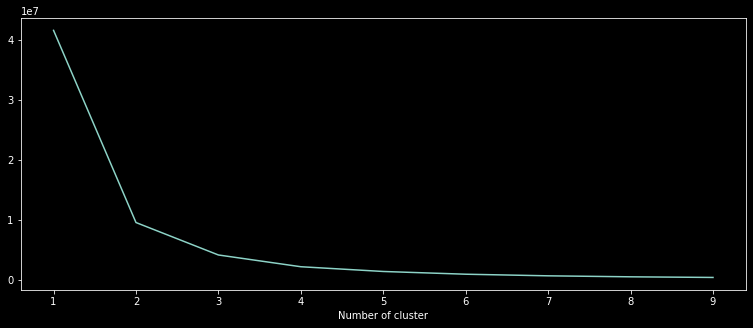

In [0]:
from sklearn.cluster import KMeans

sse={}
recency = user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [0]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster'] = kmeans.predict(user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

user = order_cluster('RecencyCluster', 'Recency',user,False)

In [0]:
user.groupby(['RecencyCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,939.0,215.667732,27.991476,174.0,189.0,214.0,240.00,271.0
1,1288.0,127.858696,21.457793,95.0,109.0,125.0,145.25,170.0
2,1758.0,60.262230,15.940022,38.0,46.0,59.0,73.00,90.0
3,4249.0,9.685573,9.952050,0.0,3.0,6.0,14.00,34.0


##Frequency

To create frequency clusters, we need to find the total number of orders for each customer. First, calculate this and see how frequency look like in our customer database

In [0]:
#get order counts for each user and create a dataframe with it
frequency = data.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
user = pd.merge(user, frequency, on='CustomerID')

#plot the histogram
plot_data = [
    go.Histogram(
        x=user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency',
        template = template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [0]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster'] = kmeans.predict(user[['Frequency']])

#order the frequency cluster
user = order_cluster('FrequencyCluster', 'Frequency',user,True)

#see details of each cluster
user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,6153.0,4.403218,4.154224,1.0,1.0,3.0,6.0,17.0
1,1210.0,31.298347,10.391322,18.0,22.0,29.0,39.0,55.0
2,533.0,79.439024,16.546657,56.0,65.0,77.0,93.0,112.0
3,338.0,144.917160,18.487600,113.0,130.0,148.0,160.0,200.0


##Revenue

Let’s see how our customer database looks like when we cluster them based on revenue. We will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [0]:
#calculate revenue for each customer
revenue = data.groupby('CustomerID').Revenue.sum().reset_index()

#merge it with our main dataframe
user = pd.merge(user, revenue, on='CustomerID')

#plot the histogram
plot_data = [
    go.Histogram(
        x=user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value',
        template = template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [0]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Revenue']])
user['RevenueCluster'] = kmeans.predict(user[['Revenue']])


#order the cluster numbers
user = order_cluster('RevenueCluster', 'Revenue',user,True)

#show details of the dataframe
user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,8154.0,2.027350e+04,5.139209e+04,33.0,748.0,3288.5,13994.75,478234.0
1,74.0,9.465091e+05,4.545144e+05,492074.0,594816.5,855567.5,1085967.00,2450008.0
2,5.0,4.750982e+06,2.337348e+06,3519236.0,3548138.0,3807737.5,3960570.00,8919230.0
3,1.0,5.204240e+07,NaN,52042405.0,52042405.0,52042405.0,52042405.00,52042405.0


##Overall Score

In [0]:
#calculate overall score and use mean() to see details
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['RevenueCluster']
user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean().astype(float).applymap('{:,.4f}'.format)

,Recency,Frequency,Revenue
OverallScore,,,
0,215.7058,1.4424,"1,528.9915"
1,127.9354,2.3160,"2,745.6163"
2,60.6690,4.4006,"4,436.9297"
3,14.9145,7.3950,"7,677.3212"
4,7.6360,31.7491,"34,179.6804"
5,2.7528,79.1283,"99,955.1681"
6,0.6444,140.7815,"182,253.6481"
7,0.3788,155.8333,"970,163.7424"
8,0.0000,166.6000,"4,750,982.3000"


In [0]:
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore']>2,'Segment'] = 'Mid-Value' 
user.loc[user['OverallScore']>4,'Segment'] = 'High-Value' 

In [0]:
#Revenue vs Frequency
graph = user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['Frequency'],
        y=graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['Frequency'],
        y=graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments',
        template = template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

#Revenue Recency

graph = user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['Recency'],
        y=graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['Recency'],
        y=graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['Recency'],
        y=graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments',
        template = template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

# Revenue vs Frequency
graph = user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=graph.query("Segment == 'Low-Value'")['Recency'],
        y=graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'Mid-Value'")['Recency'],
        y=graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment == 'High-Value'")['Recency'],
        y=graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments',
        template = template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

We can start taking actions with this segmentation. The main strategies are quite clear:

High Value: Improve Retention

Mid Value: Improve Retention + Increase Frequency

Low Value: Increase Frequency

#Customer Lifetime Value Prediction

***LTV - the amount of money that you expect to receive from a particular client during the existence of his in active phase.***

In [0]:
from datetime import datetime, timedelta,date
#create 3m and 6m dataframes
data_3m = data[(data.InvoiceDate < date(2019,3,1)) & (data.InvoiceDate >= date(2019,1,1))].reset_index(drop=True)
data_6m = data[(data.InvoiceDate >= date(2019,3,1)) & (data.InvoiceDate < date(2019,9,1))].reset_index(drop=True)

#create tx_user for assigning clustering
user = pd.DataFrame(data_3m['CustomerID'].unique())
user.columns = ['CustomerID']

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


#calculate recency score
max_purchase = data_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
user = pd.merge(user, max_purchase[['CustomerID','Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster'] = kmeans.predict(user[['Recency']])

user = order_cluster('RecencyCluster', 'Recency',user,False)

#calcuate frequency score
frequency = data_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns = ['CustomerID','Frequency']
user = pd.merge(user, frequency, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster'] = kmeans.predict(user[['Frequency']])

user = order_cluster('FrequencyCluster', 'Frequency',user,True)

revenue = data_3m.groupby('CustomerID').Revenue.sum().reset_index()
user = pd.merge(user, revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Revenue']])
user['RevenueCluster'] = kmeans.predict(user[['Revenue']])
user = order_cluster('RevenueCluster', 'Revenue',user,True)


#overall scoring
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['RevenueCluster']
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore']>2,'Segment'] = 'Mid-Value' 
user.loc[user['OverallScore']>4,'Segment'] = 'High-Value' 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.



In [0]:
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,6239,0,3,37,3,838917.0,2,8,High-Value
1,7656,0,3,36,3,887338.0,2,8,High-Value
2,2664,0,3,39,3,710154.0,2,8,High-Value
3,5920,0,3,40,3,772714.0,2,8,High-Value
4,1177,0,3,36,3,1310729.0,2,8,High-Value


In [0]:
#calculate revenue and create a new dataframe for it
user_6m = data_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
user_6m.columns = ['CustomerID','m6_Revenue']


#plot LTV histogram
plot_data = [
    go.Histogram(
        x=user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue',
        template=template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [0]:
tx_merge = pd.merge(user, user_6m, on='CustomerID', how='left')
tx_merge = tx_merge.fillna(0)

tx_graph = tx_merge.query("m6_Revenue < 30000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV',
        template=template
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [0]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
cluster = tx_merge.copy()

#see details of the clusters
cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,4500.0,8615.948533,11479.180034,0.0,586.0,3565.5,12166.25,52182.0
1,453.0,96017.147903,34514.629008,52265.0,67520.0,88460.0,117814.00,182356.0
2,125.0,274921.744800,69457.595996,188402.0,218042.0,261449.0,316479.00,463178.0


2 is the best with average 274k LTV whereas 0 is the worst with 8645.

In [0]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from __future__ import division
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#convert categorical columns to numerical
tx_class = pd.get_dummies(cluster)

#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [0]:
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,7442,2,3,20,2,1119455.0,2,7,148994.0,1,1,0,0
1,7314,0,3,29,3,121314.0,1,7,166336.0,1,1,0,0
2,4868,0,3,28,3,160647.0,1,7,178342.0,1,1,0,0
3,4441,0,3,6,1,413279.0,1,5,141151.0,1,1,0,0
4,8163,0,3,23,2,146955.0,1,6,91129.0,1,1,0,0


In [0]:
corr_matrix

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
CustomerID,1.000000,-0.002905,0.003119,0.009673,0.011603,0.029461,0.025671,0.009539,0.012419,0.018724,0.008728,-0.004900,-0.000925
Recency,-0.002905,1.000000,-0.971252,-0.470187,-0.463938,-0.194645,-0.070697,-0.881317,-0.283837,-0.254199,-0.329238,0.826792,-0.599472
RecencyCluster,0.003119,-0.971252,1.000000,0.416121,0.410889,0.170686,0.059241,0.871775,0.249065,0.219072,0.277970,-0.852975,0.659225
Frequency,0.009673,-0.470187,0.416121,1.000000,0.959501,0.439470,0.217589,0.785302,0.667350,0.639636,0.869060,-0.466163,-0.113624
FrequencyCluster,0.011603,-0.463938,0.410889,0.959501,1.000000,0.423614,0.199707,0.802023,0.633394,0.604436,0.860836,-0.485507,-0.089073
Revenue,0.029461,-0.194645,0.170686,0.439470,0.423614,1.000000,0.712519,0.372780,0.569725,0.513558,0.417294,-0.191452,-0.086560
RevenueCluster,0.025671,-0.070697,0.059241,0.217589,0.199707,0.712519,1.000000,0.199129,0.404474,0.292906,0.213119,-0.067429,-0.074199
OverallScore,0.009539,-0.881317,0.871775,0.785302,0.802023,0.372780,0.199129,1.000000,0.516279,0.475286,0.643197,-0.815053,0.380404
m6_Revenue,0.012419,-0.283837,0.249065,0.667350,0.633394,0.569725,0.404474,0.516279,1.000000,0.910662,0.584295,-0.273424,-0.115912
LTVCluster,0.018724,-0.254199,0.219072,0.639636,0.604436,0.513558,0.292906,0.475286,0.910662,1.000000,0.582384,-0.243855,-0.143869


In [0]:
#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.91749585 0.93781095]
NB [0.89220564 0.89635158]
RF [0.92993367 0.93864013]
SVC [0.8818408  0.89013267]
Dtree [0.90837479 0.91832504]
XGB [0.93698176 0.9473466 ]
KNN [0.93283582 0.93573798]


In [0]:
from sklearn.model_selection import GridSearchCV

param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch.fit(X_train,y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.9438234896247566)

In [0]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=5).fit(X_train, y_train)

In [0]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       226
           1       0.76      0.65      0.70        20
           2       0.75      0.75      0.75         8

    accuracy                           0.95       254
   macro avg       0.83      0.80      0.81       254
weighted avg       0.95      0.95      0.95       254



Precision and recall are acceptable for 0. As an example, for cluster 0 (Low LTV), if model tells us this customer belongs to cluster 0, 97 out of 100 will be correct (precision). And the model successfully identifies 99% of actual cluster 0 customers (recall). We really need to improve the model for other clusters.

#Predicting Next Purchase Day